In [5]:
# Script to plot the neigjhbors and tactile values afterwards from the deployment info
deployment_data_dir = '/home/irmak/Workspace/Holo-Bot/deployment_data/cup_picking/demo_images/image_tactile_play/4'

In [6]:
import pickle
import os
with open(os.path.join(deployment_data_dir, 'deployment_info.pkl'), 'rb') as f: 
    deployment_info = pickle.load(f)

In [7]:
deployment_info.keys()

dict_keys(['all_representations', 'curr_representations', 'closest_representations', 'neighbor_ids', 'images', 'tactile_values'])

In [8]:
# Plot the neighbors
TESTING_STATE = 62
len(deployment_info['images'])
len(deployment_info['tactile_values'])

83

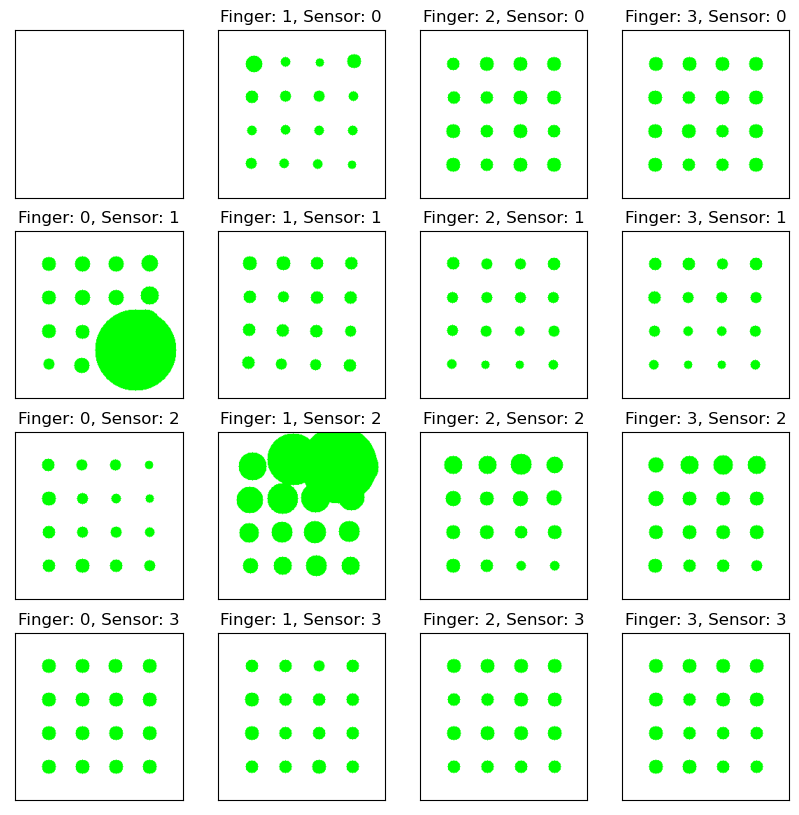

In [9]:
import matplotlib.pyplot as plt

from tactile_learning.utils.visualization import plot_tactile_sensor


def plot_tactile_state(tactile_values):
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
    for col_id in range(4):
        for row_id in range(4):
            if col_id + row_id > 0:
                plot_tactile_sensor(
                    ax = axs[row_id, col_id],
                    sensor_values = tactile_values[col_id*4+row_id-1],
                    title=f'Finger: {col_id}, Sensor: {row_id}'
                )
            axs[row_id, col_id].get_yaxis().set_ticks([])
            axs[row_id, col_id].get_xaxis().set_ticks([])
    # fig.savefig('tactile_state.png', bbox_inches='tight')
    # fig.clf()
    # plt.close()
    plt.show()
    
plot_tactile_state(deployment_info['tactile_values'][TESTING_STATE])

In [10]:
import torch
import torchvision.transforms as T
import torch.nn.functional as F

from tactile_learning.utils.constants import *

def get_tactile_image_for_visualization(tactile_values):
    def _get_whole_hand_tactile_image(tactile_values): 
        # tactile_values: (15,16,3) - turn it into 16,16,3 by concatenating 0z
        tactile_image = torch.FloatTensor(tactile_values)
        tactile_image = F.pad(tactile_image, (0,0,0,0,1,0), 'constant', 0)
        # reshape it to 4x4
        tactile_image = tactile_image.view(16,4,4,3)

        # concat for it have its proper shape
        tactile_image = torch.concat([
            torch.concat([tactile_image[i*4+j] for j in range(4)], dim=0)
            for i in range(4)
        ], dim=1)

        tactile_image = torch.permute(tactile_image, (2,0,1))
        pre_tactile_transform = T.Compose([
            T.Resize((16,16)),
            T.Lambda(_clamp_transform),
            T.Lambda(_scale_transform)
        ])
        return pre_tactile_transform(tactile_image)

    tactile_image = _get_whole_hand_tactile_image(tactile_values)
    tactile_image = T.Resize(224)(tactile_image) # Don't need another normalization
    tactile_image = (tactile_image - tactile_image.min()) / (tactile_image.max() - tactile_image.min())
    return tactile_image  

def _clamp_transform(image):
    image = torch.clamp(image, min=TACTILE_PLAY_DATA_CLAMP_MIN, max=TACTILE_PLAY_DATA_CLAMP_MAX)
    return image

def _scale_transform(image):
    image = (image - TACTILE_PLAY_DATA_CLAMP_MIN) / (TACTILE_PLAY_DATA_CLAMP_MAX - TACTILE_PLAY_DATA_CLAMP_MIN)
    return image

In [11]:
import numpy as np

np_means = np.asarray(VISION_IMAGE_MEANS)
np_stds = np.asarray(VISION_IMAGE_STDS)

inv_image_transform = T.Compose([
    T.Normalize(mean = [0,0,0], std = 1 / np_stds ), 
    T.Normalize(mean = -np_means, std = [1,1,1])
])

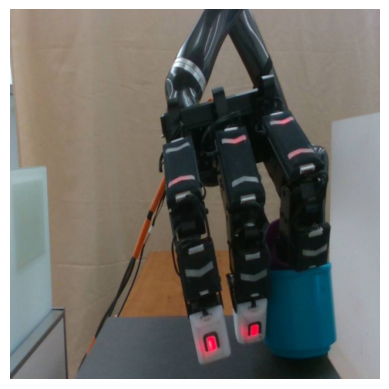

In [14]:
import cv2
def plot_curr_image(image): # - NOTE: maybe we could plot the images from the saved deployments
    image = inv_image_transform(image).numpy().transpose(1,2,0)
    image_cv2 = cv2.cvtColor(image*255, cv2.COLOR_RGB2BGR)
    # cv2.imshow(image_cv2)
    plt.imshow(image)
    plt.axis('off')
plot_curr_image(deployment_info['images'][TESTING_STATE])

In [13]:
# Get the neighbors - from the data from load_data
import glob
from torchvision.datasets.folder import default_loader as loader

def load_dataset_image(demo_id, image_id, view_num=1, data_path='/home/irmak/Workspace/Holo-Bot/extracted_data/book_opening/eval'):
    roots = glob.glob(f'{data_path}/demonstration_*')
    roots = sorted(roots)
    image_root = roots[demo_id]
    image_path = os.path.join(image_root, 'cam_{}_rgb_images/frame_{}.png'.format(view_num, str(image_id).zfill(5)))
    img = T.ToTensor()(loader(image_path)).permute(1,2,0) # We don't have to do these for this particular thinb
    return img.numpy()

# data_path = '/data/tactile_learning/deployment_data/book_opening/demonstrations/image_tactile_play_1min'
# data_path = '/home/irmak/Workspace/Holo-Bot/extracted_data/book_opening/eval'
image = load_dataset_image(demo_id=0, image_id=70, view_num=1, data_path='/home/irmak/Workspace/Holo-Bot/extracted_data/cup_picking/eval')
plt.imshow(image)
plt.axis('off')


FileNotFoundError: [Errno 2] No such file or directory: '/home/irmak/Workspace/Holo-Bot/extracted_data/cup_picking/eval/demonstration_2/cam_0_rgb_images/frame_00070.png'

In [15]:
from tactile_learning.utils.data import load_data

data_path = '/home/irmak/Workspace/Holo-Bot/extracted_data/cup_picking/eval'
roots = glob.glob(f'{data_path}/demonstration_*')
data = load_data(roots, demos_to_use=[])
def get_data_with_id_for_visualization(id):
    demo_id, tactile_id = data['tactile']['indices'][id]
    _, allegro_tip_id = data['allegro_tip_states']['indices'][id]
    _, kinova_id = data['kinova']['indices'][id]
    _, image_id = data['image']['indices'][id]
    tactile_values = data['tactile']['values'][demo_id][tactile_id]
    tactile_image = get_tactile_image_for_visualization(tactile_values)
    allegro_finger_tip_pos = data['allegro_tip_states']['values'][demo_id][allegro_tip_id]
    kinova_cart_pos = data['kinova']['values'][demo_id][kinova_id][:3]
    image = load_dataset_image(demo_id, image_id)
    # image_cv2 = cv2.cvtColor(image*255, cv2.COLOR_RGB2BGR)

    visualization_data = dict(
        image = image,
        kinova = kinova_cart_pos, 
        allegro = allegro_finger_tip_pos, 
        tactile_values = tactile_values,
        tactile_image = tactile_image
    )

    return visualization_data

In [16]:
neighbor_id = deployment_info['neighbor_ids'][TESTING_STATE]

In [17]:
print(neighbor_id)

158


In [18]:
neighbor_vis_data = get_data_with_id_for_visualization(neighbor_id)

IndexError: list index out of range

(-0.5, 1279.5, 719.5, -0.5)

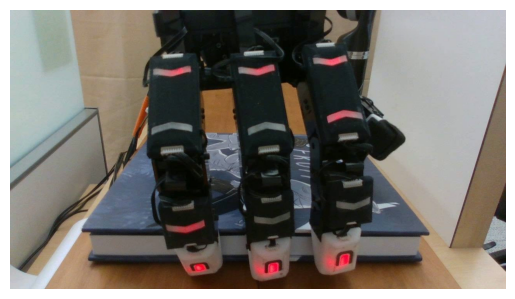

In [61]:
plt.imshow(neighbor_vis_data['image'])
plt.axis('off')